# **RoNIN Batch Analysis Pipeline**
### **Benchmark of Manifold-Aware Filters for 6DoF Pose Estimation**

**Authors:**  Ilya Afanasyev  
**Project:**  Filter-based (ESKF, UKF) vs Observer-based (GeoDQ) Fusion Strategies  

### **Overview**

This notebook implements a comprehensive evaluation pipeline for 6DoF pose estimation algorithms on the **RoNIN dataset**. It benchmarks three distinct architectures for Inertial Navigation Systems (INS) aided by global position updates via Visual Odometry (VO), comparing standard Python implementations against Numba-optimized (JIT) versions:

1.  **ESKF**: Standard Error-State Kalman Filter (Baseline).
2.  **UKF-M**: Manifold-aware Unscented Kalman Filter (Sigma-point based).
3.  **GeoDQ**: Geometric Dual Quaternion Observer (Non-linear Observer on $SE(3)$).

The pipeline includes trajectory processing, accuracy metrics (RMSE, ATE), execution time profiling, and robustness tests against sparse VO/GPS updates.

---

## Cell 1: Environment Setup and Imports

In [1]:
import sys
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm 

# --- Project Path Configuration ---
# Automatically add the project root (one level up) to sys.path
# This ensures we can import modules from 'algorithms/'
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"✓ Project root added to system path: {project_root}")

# --- Visualization Settings ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# High-contrast scientific color palette for publication
COLORS = {
    'GT': '#000000',       # Ground Truth - Black
    'ESKF': '#9467bd',     # ESKF - Purple
    'ESKF-JIT': '#9467bd', # ESKF (JIT) - Purple
    'UKF': '#1f77b4',      # UKF-M - Blue
    'UKF-JIT': '#1f77b4',  # UKF-M (JIT) - Blue
    'GeoDQ': '#d62728',    # GeoDQ - Red
    'GeoDQ-JIT': '#d62728' # GeoDQ (JIT) - Red (Proposed Method)
}

print("✓ Environment initialized successfully.")

✓ Project root added to system path: d:\test\SE3-Manifold-Lib
✓ Environment initialized successfully.


## Cell 2: Path Configuration

In [2]:
# --- Dataset Configuration ---
# Note: Update 'BASE_DATA_PATH' to match your local storage directory if needed.
BASE_DATA_PATH = Path('D:/test/RoNIN_Standardized_Dataset')

# Define input/output paths
DATA_DIR = BASE_DATA_PATH / 'csv_data'
RESULT_DIR = BASE_DATA_PATH / 'results_Benchmark_GeoDQ'

# Ensure dataset exists before proceeding
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Dataset not found at: {DATA_DIR}. Please check the path.")

# Create output directories for Plots and Statistics
PLOTS_DIR = RESULT_DIR / 'plots'
STATS_DIR = RESULT_DIR / 'statistics'

for folder in [PLOTS_DIR, STATS_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

# List available trajectories in the dataset
trajectories = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])

print(f"✓ Data Directory: {DATA_DIR}")
print(f"✓ Results Directory: {RESULT_DIR}")
print(f"✓ Found {len(trajectories)} trajectories ready for processing.")

✓ Data Directory: D:\test\RoNIN_Standardized_Dataset\csv_data
✓ Results Directory: D:\test\RoNIN_Standardized_Dataset\results_Benchmark_GeoDQ
✓ Found 35 trajectories ready for processing.


## Cell 3: Load Filter Kernels

In [3]:
# --- Import Algorithm Classes ---
# We import specific classes from the modules in the 'algorithms' package.
# NOTE: Ensure the class names below match exactly what is defined inside your .py files.

try:
    # 1. Error-State Kalman Filter Classes
    # Assuming class 'ESKF_INS' is inside 'algorithms/filters/eskf.py'
    from algorithms.filters.eskf import ESKF_INS
    from algorithms.filters.eskf_jit import ESKF_INS_JIT
    
    # 2. Unscented Kalman Filter on Manifold Classes
    # Assuming class 'UKF_M' is inside 'algorithms/filters/ukfm.py'
    from algorithms.filters.ukfm import UKF_M
    from algorithms.filters.ukfm_jit import UKF_M_JIT
    
    # 3. Geometric Dual Quaternion Observer Classes
    # Assuming class 'DQFilter' is inside 'algorithms/geodq/geodq_sclerp.py'
    from algorithms.geodq.geodq_sclerp import DQFilter
    from algorithms.geodq.geodq_sclerp_jit import DQFilterJIT
    
    print("✓ All algorithm classes imported successfully.")
    print(f"  - ESKF: {ESKF_INS}")
    print(f"  - GeoDQ: {DQFilter}")

except ImportError as e:
    print(f"❌ Import Error: {e}")
    print("Troubleshooting:")
    print("1. Check if '__init__.py' exists in 'algorithms' folders.")
    print("2. Verify that the CLASS name inside the .py file matches the import above.")
    raise
except AttributeError as e:
    print(f"❌ Class Name Error: {e}")
    print("The file was found, but the Class was not found inside it.")
    print("Please check the .py files to see the exact name of the classes.")
    raise

✓ All algorithm classes imported successfully.
  - ESKF: <class 'algorithms.filters.eskf.ESKF_INS'>
  - GeoDQ: <class 'algorithms.geodq.geodq_sclerp.DQFilter'>


## Cell 4: Visualization Engine

In [4]:
def plot_benchmark_results(traj_id, data, output_path):
    """
    Generates a 4-panel comparison figure for trajectory analysis.
    Plots Ground Truth vs. Estimated trajectories and error metrics.
    """
    gt = data['gt']
    
    # Initialize figure layout
    fig = plt.figure(figsize=(18, 12), dpi=120, facecolor='white')
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 2])
    
    # --- Panel 1: 3D Trajectory View ---
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    ax1.plot(gt[:, 0], gt[:, 1], gt[:, 2], color=COLORS['GT'], label='Ground Truth', lw=2.5)
    
    # Plot estimators (Using JIT versions for visualization)
    ax1.plot(data['p_eskf'][:, 0], data['p_eskf'][:, 1], data['p_eskf'][:, 2], 
             color=COLORS['ESKF'], label='ESKF', lw=1.5, alpha=0.7)
    ax1.plot(data['p_ukf'][:, 0], data['p_ukf'][:, 1], data['p_ukf'][:, 2], 
             color=COLORS['UKF'], label='UKF-M', lw=1.8)
    ax1.plot(data['p_dq'][:, 0], data['p_dq'][:, 1], data['p_dq'][:, 2], 
             color=COLORS['GeoDQ'], label='GeoDQ', lw=1.8, ls='--', alpha=0.9)
    
    ax1.set_title(f"3D Trajectory Comparison: {traj_id}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("X [m]"); ax1.set_ylabel("Y [m]"); ax1.set_zlabel("Z [m]")
    ax1.legend()

    # --- Panel 2: Top-Down (XY) Projection ---
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(gt[:, 0], gt[:, 1], color=COLORS['GT'], lw=2.5, label='GT')
    ax2.plot(data['p_eskf'][:, 0], data['p_eskf'][:, 1], color=COLORS['ESKF'], lw=1.5, alpha=0.7)
    ax2.plot(data['p_ukf'][:, 0], data['p_ukf'][:, 1], color=COLORS['UKF'], lw=1.8)
    ax2.plot(data['p_dq'][:, 0], data['p_dq'][:, 1], color=COLORS['GeoDQ'], lw=1.8, ls='--', alpha=0.9)
    
    ax2.set_aspect('equal')
    ax2.set_title("XY Top-Down Projection", fontsize=14, fontweight='bold')
    ax2.set_xlabel("X [m]"); ax2.set_ylabel("Y [m]")
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- Panel 3: Euclidean Error Evolution ---
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(data['err_eskf'], color=COLORS['ESKF'], alpha=0.5, label='ESKF')
    ax3.plot(data['err_ukf'], color=COLORS['UKF'], lw=1.5, label='UKF-M')
    ax3.plot(data['err_dq'], color=COLORS['GeoDQ'], alpha=0.8, ls='--', label='GeoDQ')
    
    ax3.set_title("Pose Error Over Time", fontsize=14, fontweight='bold')
    ax3.set_ylabel("Error [meters]"); ax3.set_xlabel("Sample Index")
    ax3.legend(ncol=3, loc='upper right')

    # --- Panel 4: Error Statistical Distribution (Boxplots) ---
    ax4 = fig.add_subplot(gs[1, 1])
    error_data = [data['err_eskf'], data['err_ukf'], data['err_dq']]
    labels = ['ESKF', 'UKF-M', 'GeoDQ']
    
    bp = ax4.boxplot(error_data, patch_artist=True, labels=labels, notch=True)
    
    # Colorize boxplots
    colors_list = [COLORS['ESKF'], COLORS['UKF'], COLORS['GeoDQ']]
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax4.set_title("Error Statistics Distribution", fontsize=14, fontweight='bold')
    ax4.set_ylabel("RMSE Distribution [m]")

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()
    
    return str(output_path)

## Cell 5: RoNIN Benchmark Core

In [5]:
class RoNINBenchmark:
    """
    Core engine for benchmarking 6DoF filters on the RoNIN dataset.
    Handles data loading, filtering loop execution, metric calculation, and robustness testing.
    """    
    def __init__(self, data_dir, plots_dir, stats_dir):
        self.data_dir = Path(data_dir)
        self.plots_dir = Path(plots_dir)
        self.stats_dir = Path(stats_dir)
        self.dt = 0.005 # Default dt for 200Hz, will be updated based on data

    def _load_trajectory_data(self, traj_id):
        """
        Loads IMU and Ground Truth (Pose) data.
        Prioritizes Visual Odometry (vo.csv), falls back to GPS (gps.csv).
        """
        p = self.data_dir / traj_id
        imu_path = p / 'imu.csv'
        
        vo_path = p / 'vo.csv'
        if not vo_path.exists():
            vo_path = p / 'gps.csv'
            
        if not imu_path.exists() or not vo_path.exists():
            raise FileNotFoundError(f"Missing data files in {p}. Ensure imu.csv and vo/gps.csv exist.")
            
        imu_df = pd.read_csv(imu_path)
        vo_df = pd.read_csv(vo_path) 
        return imu_df, vo_df

    def _get_metrics(self, est, gt):
        """Calculates RMSE (Root Mean Square Error) and ATE (Absolute Trajectory Error)."""
        errors = np.linalg.norm(np.array(est) - gt, axis=1)
        return {
            'rmse': np.sqrt(np.mean(errors**2)),
            'ate': np.mean(errors),
            'raw_errors': errors
        }

    def process_sequence(self, traj_id, show_plot=True):
        """
        Runs all 6 filters (Standard & JIT) on a single trajectory.
        Returns metrics dictionary and processing time.
        """
        imu_data, vo_data = self._load_trajectory_data(traj_id)
        
        # Extract sensor data
        t_imu = imu_data['time'].values
        acc = imu_data[['ax','ay','az']].values
        gyro = imu_data[['wx','wy','wz']].values
        
        # Extract Ground Truth
        t_gt = vo_data['time'].values
        gt_pos = vo_data[['X','Y','Z']].values
        
        # Calculate true sampling rate
        dt = np.mean(np.diff(t_imu))
        self.dt = dt
        N = len(t_imu)
        
        # Initialization states (Float64 for precision)
        p0 = gt_pos[0].astype(np.float64)
        q0 = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)
        
        # Interpolate Ground Truth to IMU timestamps for evaluation
        gt_interp = np.array([np.interp(t_imu, t_gt, gt_pos[:, k]) for k in range(3)]).T

        # --- 1. Initialize Filters ---
        # Note: Classes are imported globally in Cell 3
        
        # ESKF
        eskf = ESKF_INS(dt, R_pos=np.eye(3)*0.25)
        eskf.set_state(p0, np.zeros(3), q0)
        
        eskf_jit = ESKF_INS_JIT(dt, R_pos=np.eye(3)*0.25)
        eskf_jit.set_state(p0, np.zeros(3), q0)

        # UKF-M
        ukf = UKF_M(dt, R_pos=0.5)
        ukf.set_init(p0, q0)
        
        ukf_jit = UKF_M_JIT(dt, R_pos=0.5)
        ukf_jit.set_init(p0, q0)
        
        # GeoDQ
        dq = DQFilter(dt, kp_vel=0.8, ki_ba=0.01)
        dq.initialize(q0, p0)
        
        dq_jit = DQFilterJIT(dt, kp_vel=0.8, ki_ba=0.01)
        # JIT Warmup (compile with dummy data)
        dq_jit.step(np.zeros(3), np.zeros(3), np.zeros(3))
        dq_jit.initialize(q0, p0)

        # Storage
        methods = ['eskf', 'eskf_jit', 'ukf', 'ukf_jit', 'dq', 'dq_jit']
        results = {m: np.zeros((N, 3)) for m in methods}
        timers = {m: 0.0 for m in methods}

        # --- 2. Main Processing Loop ---
        for i in range(N):
            # 2.1 ESKF
            t_s = time.perf_counter()
            eskf.predict(gyro[i], acc[i]); eskf.update_vo(gt_interp[i])
            results['eskf'][i] = eskf.p
            timers['eskf'] += (time.perf_counter() - t_s)

            t_s = time.perf_counter()
            eskf_jit.predict(gyro[i], acc[i]); eskf_jit.update_vo(gt_interp[i])
            results['eskf_jit'][i] = eskf_jit.p
            timers['eskf_jit'] += (time.perf_counter() - t_s)

            # 2.2 UKF-M
            t_s = time.perf_counter()
            ukf.predict(gyro[i], acc[i]); ukf.update(gt_interp[i])
            results['ukf'][i] = ukf.position
            timers['ukf'] += (time.perf_counter() - t_s)

            t_s = time.perf_counter()
            ukf_jit.predict(gyro[i], acc[i]); ukf_jit.update(gt_interp[i])
            results['ukf_jit'][i] = ukf_jit.position
            timers['ukf_jit'] += (time.perf_counter() - t_s)
            
            # 2.3 GeoDQ
            t_s = time.perf_counter()
            dq.step(gyro[i], acc[i], pos_meas=gt_interp[i])
            results['dq'][i] = dq.position
            timers['dq'] += (time.perf_counter() - t_s)

            t_s = time.perf_counter()
            dq_jit.step(gyro[i], acc[i], pos_meas=gt_interp[i])
            results['dq_jit'][i] = dq_jit.position
            timers['dq_jit'] += (time.perf_counter() - t_s)

        # --- 3. Compute Metrics ---
        metrics = {}
        for m in methods:
            metrics[m] = self._get_metrics(results[m], gt_interp)

        # --- 4. Generate Plot ---
        fig_path = None
        if show_plot:
            fig_path = self.plots_dir / f"{traj_id}_result.png"
            plot_benchmark_results(traj_id, {
                'gt': gt_interp, 
                'p_eskf': results['eskf_jit'], 
                'p_ukf': results['ukf_jit'], 
                'p_dq': results['dq_jit'],
                'err_eskf': metrics['eskf_jit']['raw_errors'], 
                'err_ukf': metrics['ukf_jit']['raw_errors'], 
                'err_dq': metrics['dq_jit']['raw_errors']
            }, fig_path)

        # Compile Return Data
        ret = {'trajectory': traj_id, 'plot': str(fig_path) if fig_path else None}
        for m in methods:
            ret[f'rmse_{m}'] = metrics[m]['rmse']
            ret[f'ate_{m}'] = metrics[m]['ate']
            ret[f'time_{m}'] = timers[m] * 1000 # Convert to ms
            
        return ret

    def run_robustness_test(self, traj_list, max_decimation=10, is_batch=False):
        """
        Stress Test: Evaluates performance with sparse Position (VO) updates (Decimation).
        """
        intervals = np.arange(1, max_decimation + 1)
        stats = {m: {i: [] for i in intervals} for m in ['ESKF', 'UKF', 'GeoDQ']}
        
        print(f"Starting robustness test on {len(traj_list)} trajectories...")
        
        for traj_id in tqdm(traj_list, desc="Robustness Loop"):
            imu_data, vo_data = self._load_trajectory_data(traj_id)
            
            # Prepare data (Shortened for brevity - essentially same as process_sequence)
            t_imu = imu_data['time'].values
            acc = imu_data[['ax','ay','az']].values
            gyro = imu_data[['wx','wy','wz']].values
            t_gt = vo_data['time'].values
            gt_pos = vo_data[['X','Y','Z']].values
            
            dt = np.mean(np.diff(t_imu))
            p0 = gt_pos[0].astype(np.float64)
            q0 = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)
            gt_interp = np.array([np.interp(t_imu, t_gt, gt_pos[:, k]) for k in range(3)]).T
            N = len(t_imu)

            for step in intervals:
                # Initialize JIT Filters for Speed
                f_eskf = ESKF_INS_JIT(dt, R_pos=np.eye(3)*0.25); f_eskf.set_state(p0, np.zeros(3), q0)
                f_ukf = UKF_M_JIT(dt, R_pos=0.5); f_ukf.set_init(p0, q0)
                f_dq = DQFilterJIT(dt, kp_vel=0.8, ki_ba=0.01); f_dq.initialize(q0, p0)
                # Warmup
                f_dq.step(np.zeros(3), np.zeros(3), np.zeros(3)); f_dq.initialize(q0, p0)
                
                sse = {'ESKF': 0.0, 'UKF': 0.0, 'GeoDQ': 0.0}
                
                for i in range(N):
                    # Simulate sparse updates
                    pos_meas = gt_interp[i] if (i % step == 0) else None
                    
                    f_eskf.predict(gyro[i], acc[i])
                    if pos_meas is not None: f_eskf.update_vo(pos_meas)
                        
                    f_ukf.predict(gyro[i], acc[i])
                    if pos_meas is not None: f_ukf.update(pos_meas)
                    
                    f_dq.step(gyro[i], acc[i], pos_meas=pos_meas)
                    
                    sse['ESKF'] += np.sum((f_eskf.p - gt_interp[i])**2)
                    sse['UKF']  += np.sum((f_ukf.position - gt_interp[i])**2)
                    sse['GeoDQ']+= np.sum((f_dq.position - gt_interp[i])**2)

                for m in stats.keys():
                    stats[m][step].append(np.sqrt(sse[m] / N))

        self._plot_robustness(stats, intervals, is_batch, traj_list[0] if not is_batch else "Global")
        return stats

    def _plot_robustness(self, stats, intervals, is_batch, title_suffix):
        plt.figure(figsize=(13, 8), dpi=120)
        
        styles = {
            'ESKF': {'ls': '-', 'lw': 2.5, 'marker': 'o', 'ms': 6},
            'UKF':  {'ls': '-', 'lw': 2.5, 'marker': '^', 'ms': 6},
            'GeoDQ':{'ls': '--', 'lw': 3.0, 'marker': 's', 'ms': 6, 'alpha': 0.8}
        }
        
        for m in stats.keys():
            means = [np.mean(stats[m][i]) for i in intervals]
            plt.plot(intervals, means, color=COLORS.get(m, '#333333'), label=m, **styles.get(m, {}))
            if is_batch:
                stds = [np.std(stats[m][i]) for i in intervals]
                plt.fill_between(intervals, np.array(means)-stds, np.array(means)+stds, 
                                 color=COLORS.get(m, '#333333'), alpha=0.1)

        plt.yscale('log')
        plt.grid(True, which="both", alpha=0.3)
        plt.xlabel("Position Update Interval (Samples @ 200Hz)")
        plt.ylabel("RMSE [m] (Log Scale)")
        plt.title(f"Robustness Analysis: {title_suffix}")
        plt.legend()
        
        fname = "global_robustness.png" if is_batch else f"{title_suffix}_robustness.png"
        plt.savefig(self.stats_dir / fname, bbox_inches='tight')
        plt.show()

## Cell 6: Run Fast Validation

In [11]:
# Initialize the Benchmark Engine
analyzer = RoNINBenchmark(DATA_DIR, PLOTS_DIR, STATS_DIR)

# Run Fast Validation on the first available trajectory
if trajectories:
    print(f"Running validation on sequence: {trajectories[0]} ...")
    res = analyzer.process_sequence(trajectories[0])
    
    # Formatted Output Table
    print("\n" + "="*45)
    print(f"{'Method':<12} | {'RMSE [m]':<10} | {'Time [ms]':<10}")
    print("-" * 45)
    print(f"{'ESKF':<12} | {res['rmse_eskf']:.4f}     | {res['time_eskf']:.1f}")
    print(f"{'ESKF-JIT':<12} | {res['rmse_eskf_jit']:.4f}     | {res['time_eskf_jit']:.1f}")
    print(f"{'UKF-M':<12} | {res['rmse_ukf']:.4f}     | {res['time_ukf']:.1f}")
    print(f"{'UKF-M-JIT':<12} | {res['rmse_ukf_jit']:.4f}     | {res['time_ukf_jit']:.1f}")
    print(f"{'GeoDQ':<12} | {res['rmse_dq']:.4f}     | {res['time_dq']:.1f}")
    print(f"{'GeoDQ-JIT':<12} | {res['rmse_dq_jit']:.4f}     | {res['time_dq_jit']:.1f}")
    print("="*45 + "\n")
    print(f"Plot saved to: {res['plot']}")
else:
    print("No trajectories found in the dataset directory.")

Running validation on sequence: a000_11 ...

Method       | RMSE [m]   | Time [ms] 
---------------------------------------------
ESKF         | 0.1548     | 4760.0
ESKF-JIT     | 0.1548     | 1483.7
UKF-M        | 0.2669     | 19468.7
UKF-M-JIT    | 0.2642     | 6708.5
GeoDQ        | 0.0456     | 9621.3
GeoDQ-JIT    | 0.0456     | 1296.6

Plot saved to: D:\test\RoNIN_Standardized_Dataset\results_Benchmark_GeoDQ\plots\a000_11_result.png


## Cell 7: Single Trajectory Robustness

Running robustness sensitivity test on: a000_11...
Starting robustness test on 1 trajectories...


Robustness Loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [06:28<00:00, 388.98s/it]


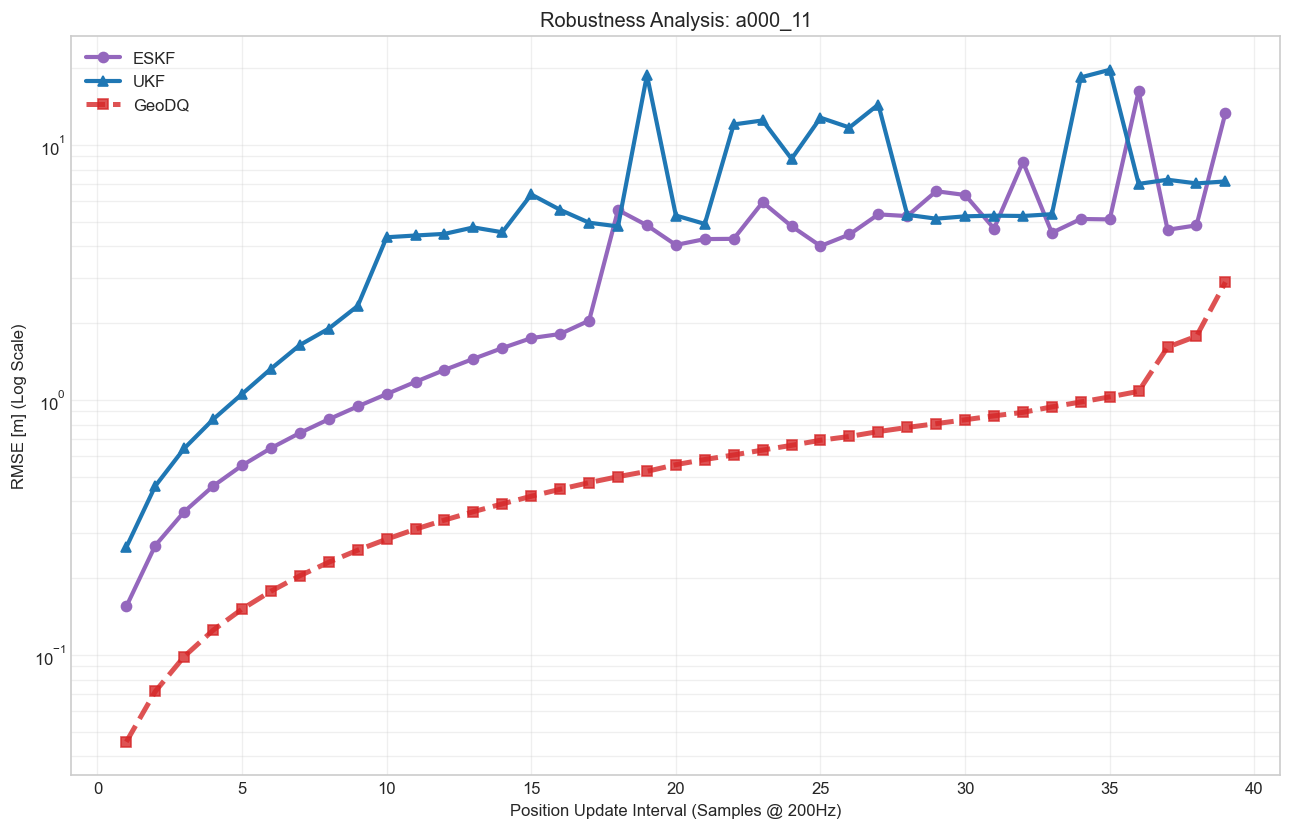

In [7]:
# --- Sensitivity Analysis (Single Trajectory) ---
# Evaluates how performance degrades as Position (VO) updates become sparser.
# We test decimation factors from 1 (every sample) to 39 (every 39th sample).
# JIT-compiled kernels are used to ensure rapid execution.

if trajectories:
    print(f"Running robustness sensitivity test on: {trajectories[0]}...")
    robustness_single = analyzer.run_robustness_test(
        trajectories[:1], 
        max_decimation=39, 
        is_batch=False
    )
else:
    print("Skipping robustness test: No trajectories found.")

## Cell 8: Batch Processing Execution

In [8]:
# --- Batch Processing (Full Dataset) ---
# Runs the benchmark pipeline on all available trajectories.
# Results are saved to a CSV file for further analysis.

print(f"🚀 Starting Full Benchmark Pipeline on {len(trajectories)} trajectories...")

# Execute processing loop with progress bar
all_results = [
    analyzer.process_sequence(t, show_plot=True) 
    for t in tqdm(trajectories, desc="Benchmarking")
]

# Export detailed results to CSV
df_results = pd.DataFrame(all_results)
csv_path = STATS_DIR / 'detailed_benchmark_results.csv'
df_results.to_csv(csv_path, index=False)
print(f"✓ Batch processing complete. Results saved to: {csv_path}")

🚀 Starting Full Benchmark Pipeline on 35 trajectories...


Benchmarking: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [55:17<00:00, 94.79s/it]

✓ Batch processing complete. Results saved to: D:\test\RoNIN_Standardized_Dataset\results_Benchmark_GeoDQ\statistics\detailed_benchmark_results.csv


## Cell 9: Statistical Analysis and Reporting

In [9]:
# --- Statistical Summary & Reporting ---
# Aggregates results to compute Mean RMSE and Average Execution Time.

# Filter out failed runs (if any)
valid_df = df_results.drop(columns=['plot'], errors='ignore').dropna()

if valid_df.empty:
    print("⚠️ Warning: No valid data available for summary.")
else:
    def get_stats_row(display_name, key_suffix):
        """Helper to format Mean ± Std for RMSE and Mean for Time."""
        rmse_col = f'rmse_{key_suffix}'
        time_col = f'time_{key_suffix}'
        
        if rmse_col not in valid_df.columns:
            return [display_name, "N/A", "N/A"]
            
        rmse_val = valid_df[rmse_col]
        time_val = valid_df[time_col]
        
        # Format: "Mean ± Std"
        rmse_str = f"{rmse_val.mean():.4f} ± {rmse_val.std():.4f}"
        time_str = f"{time_val.mean():.1f}"
        return [display_name, rmse_str, time_str]

    # Construct Summary Table
    summary_data = [
        get_stats_row("ESKF (Standard)", "eskf"),
        get_stats_row("ESKF (JIT)",      "eskf_jit"),
        get_stats_row("UKF-M (Standard)","ukf"),
        get_stats_row("UKF-M (JIT)",     "ukf_jit"),
        get_stats_row("GeoDQ (Standard)","dq"),
        get_stats_row("GeoDQ (JIT)",     "dq_jit")
    ]

    summary_df = pd.DataFrame(summary_data, columns=['Method', 'RMSE [m]', 'Avg Time [ms]'])

    print("\n" + "="*65)
    print("FINAL BENCHMARK SUMMARY (Mean ± Std Dev)")
    print("="*65)
    # Using to_string for better compatibility across environments than to_markdown
    print(summary_df.to_string(index=False, col_space=15, justify='center'))
    print("="*65)


FINAL BENCHMARK SUMMARY (Mean ± Std Dev)
     Method          RMSE [m]     Avg Time [ms] 
 ESKF (Standard) 0.1409 ± 0.0213     10242.8    
      ESKF (JIT) 0.1409 ± 0.0213      3189.2    
UKF-M (Standard) 0.2329 ± 0.0382     41492.6    
     UKF-M (JIT) 0.2312 ± 0.0378     14624.7    
GeoDQ (Standard) 0.0377 ± 0.0081     21054.7    
     GeoDQ (JIT) 0.0377 ± 0.0081      2813.6    


## Cell 10: Global Robustness Test

Starting Global Robustness Analysis...
Starting robustness test on 35 trajectories...


Robustness Loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [13:37:43<00:00, 1401.81s/it]


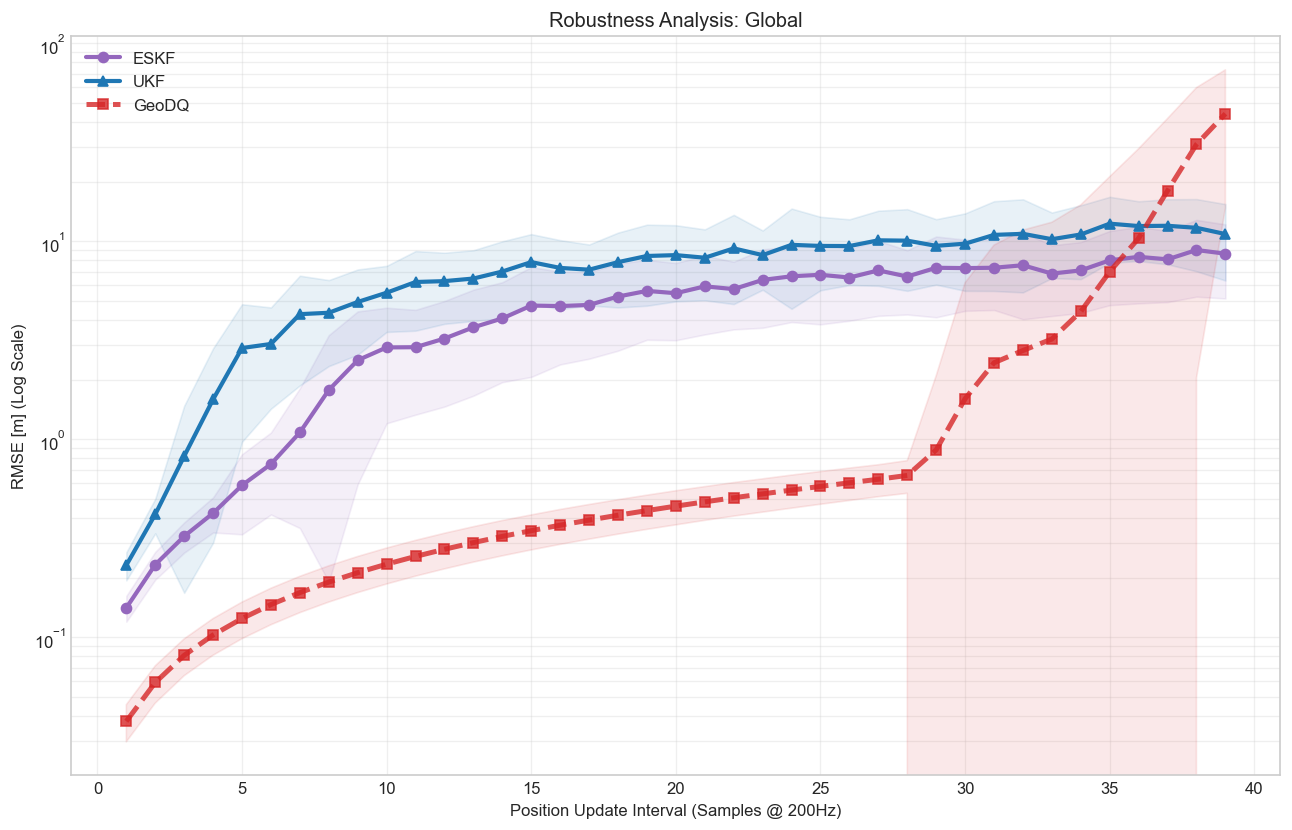

✓ Global robustness test complete.


In [10]:
# --- Global Robustness Test (Full Dataset) ---
# Computes average performance degradation across ALL trajectories.
# This test simulates challenging conditions with sparse position updates.
# Note: This may take time depending on dataset size.

if trajectories:
    print("Starting Global Robustness Analysis...")
    global_robustness = analyzer.run_robustness_test(
        trajectories, 
        max_decimation=39, 
        is_batch=True
    )
    print("✓ Global robustness test complete.")